2015 CAASPP test results.


* [Source Website](http://caaspp.cde.ca.gov/sb2015/ResearchFileList)
* [Data Dictionary](http://caaspp.cde.ca.gov/sb2015/research_fixfileformat)



In [217]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
df = pd.read_csv('../ca2015_all_csv_v1.txt', na_values='*'  )
ent = pd.read_csv('../ca2015entities_csv.txt')

df = df[df['Test Id'] == 1]

def f(x):
    return "{:02d}{:05d}{:07d}".format(x['County Code'],x['District Code'],x['School Code'])
   
df['cds'] = df.apply(f, axis=1)
ent['cds'] = ent.apply(f, axis=1)
ent.set_index('cds',inplace = True)

county_names = ent['County Name']
school_names = ent['School Name']
district_names = ent[['District Name', 'County Name']]

race_eth_subgroups = [200,202,203,204,206]+[220, 222, 223, 224, 226]
race_eth_names = ['BlackED', 'AsianED', 'FilipinoED' , 'LatinoED', 'WhiteED', 
                    'BlackP', 'AsianP', 'FilipinoP' , 'LatinoP', 'WhiteP']


subgroups = pd.read_csv('../Subgroups.txt', header=None, names = ['subgroup_id','subgroup_name','category'],
                       index_col = 0)


In [251]:

def geo_decomp(grade):
    def subset(grade, df):
        dfs = df[['cds', 'County Code', 'Subgroup ID', 'Total Tested At Subgroup Level', 'Grade','Mean Scale Score', 
             'Percentage Standard Met and Above']]
        dfs.columns = [u'cds', 'county',  u'subgroup', u'subgroup_tested', u'grade', u'mss', u'pct_msa']

        return dfs[dfs.grade == grade]

    schools = subset(grade, df[df['School Code'] != 0])
    districts =  subset(grade, df[(df['District Code'] != 0) & (df['School Code'] == 0)])
    counties =  subset(grade, df[ (df['County Code'] != 0) & (df['District Code'] == 0) & (df['School Code'] == 0)])
    states =  subset(grade, df[ (df['County Code'] == 0)])

    counties_p = pd.pivot_table(county,index='cds', columns='subgroup', values='pct_msa')
    districts_p = pd.pivot_table(district[district.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    schools_p = pd.pivot_table(schools[schools.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    
    return (state, counties, counties_p, districts, districts_p, schools, schools_p)
   
# Join Names!
# .join(district_names,how='left', rsuffix='_r')
   
def district_subgroups(grade, subgroup_ids):
    
    (state, counties, counties_p, districts, districts_p, schools, schools_p) = geo_decomp(grade)
    
    ed = districts[districts.subgroup.isin(subgroup_ids) & (districts.county == 37)]
    
    df =  pd.pivot_table(ed,index='cds', columns='subgroup', values='pct_msa')\
    .join(district_names,how='left', rsuffix='_r').sort(subgroup_ids[0], ascending=False)
    
    #df =  pd.pivot_table(ed[districts.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')\
    #.join(district_names,how='left', rsuffix='_r').sort(subgroup_ids[0], ascending=False)
    
    subgroup_names = subgroups.to_dict()['subgroup_name']
    
    # Convert
    df.columns = [ subgroup_names.get(e,e).strip().strip('"') for e in df.columns ]
    
    return df


# Codes for San Diego

The county code for San Diego county is 37


# Economic Disadvantage

31 = Economically Disadvantaged
111 = Not Exonomically Disadvantaged

The most important stats here are the Mean and Median ( listed as 50% ) 

Note that the mean and mediand values are different in each case, even though we are averaging across the whole state. This is because the averages aren't weighted, so, for instance, the average of a small district is just and important as a large one, when the larger one should be weighed by its size. 


## State Average

In [197]:
state[(state.subgroup == 31) | (state.subgroup == 111) ]


,cds,county,subgroup,subgroup_tested,grade,mss,pct_msa
113,00000000000000,0,31,2179336,3,2375.9,24
336,00000000000000,0,111,1484033,3,2447.6,59


## County Average

In [198]:
county[(county.county == 37) & ( county.subgroup.isin((31,111)))]

,cds,county,subgroup,subgroup_tested,grade,mss,pct_msa
2034275,37000000000000,37,31,152522,3,2387.2,30
2034499,37000000000000,37,111,140374,3,2458.3,64


In [199]:
county_p[[31,111]].describe().T

,count,mean,std,min,25%,50%,75%,max
31,57,24.052632,5.214749,15,21,23,26,42
111,57,53.263158,10.024125,30,48,54,60,75


## Disadvantage, by San Diego County District 

Ranked by MSA for non-disadvantaged.

*Note* When limited to 3rd grade, why does list include Sweetwater Union High? 


In [254]:
district_subgroups(3, (3,4))

,Males,Females,District Name,County Name
cds,,,,
37683870000000,84,84,Solana Beach Elementary,San Diego
37680560000000,81,89,Del Mar Union Elementary,San Diego
37683120000000,73,86,Rancho Santa Fe Elementary School Distri,San Diego
37680310000000,66,71,Coronado Unified,San Diego
37735510000000,66,76,Carlsbad Unified,San Diego
37683530000000,65,67,San Pasqual Union Elementary School Dist,San Diego
37682960000000,63,72,Poway Unified,San Diego
37680800000000,63,67,Encinitas Union Elementary School Distri,San Diego
37680070000000,59,71,Cardiff Elementary School District,San Diego


*note* Explore Borrego springs. They have 68% ED pass, but very low numbers for male and female. 

In [252]:
district_subgroups(3, (31,111))

,Economically Disadvantaged,Not Economically Disadvantaged,District Name,County Name
cds,,,,
37680560000000,61,87,Del Mar Union Elementary,San Diego
37684370000000,52,NaN,Vallecitos Elementary School District,San Diego
37754160000000,46,NaN,Warner Unified,San Diego
37683870000000,45,88,Solana Beach Elementary,San Diego
37735510000000,44,79,Carlsbad Unified,San Diego
37683610000000,41,57,Santee School District,San Diego
37680230000000,37,62,Chula Vista Elementary,San Diego
37680070000000,36,68,Cardiff Elementary School District,San Diego
37768510000000,35,60,Bonsall Unified,San Diego


In [253]:
district_subgroups(3, (120, 8,180))

,Reclassified-Fluent English Proficient (R-FEP),English Learners Enrolled in School in the U.S. Less Than 12 Months,English Only,District Name,County Name
cds,,,,,
37682960000000,95,42,68,Poway Unified,San Diego
37680230000000,91,23,56,Chula Vista Elementary,San Diego
37683380000000,55,22,57,San Diego Unified,San Diego
37679910000000,83,18,45,Cajon Valley Union,San Diego
37103710000000,NaN,NaN,0,San Diego County Office Of Education,San Diego
37679670000000,NaN,NaN,38,Alpine Union Elementary School District,San Diego
37679830000000,NaN,NaN,NaN,Borrego Springs Unified,San Diego
37680070000000,NaN,NaN,64,Cardiff Elementary School District,San Diego
37680310000000,NaN,NaN,71,Coronado Unified,San Diego


# Race-Ethinicity

In [108]:
county_p_race = county_p[race_eth_subgroups]
county_p_race.columns = race_eth_names
LatinoEd.describe()

,BlackED,AsianED,FilipinoED,LatinoED,WhiteED,BlackP,AsianP,FilipinoP,LatinoP,WhiteP
count,50.000000,50.000000,43.000000,57.000000,57.000000,43.000000,50.000000,46.000000,57.000000,58.000000
mean,23.263238,47.314167,44.300166,25.976817,37.398392,42.522287,68.467143,66.365761,46.056892,61.748461
std,6.599290,10.562115,10.702880,4.257864,6.269325,8.288520,14.964279,8.226695,6.845859,9.237010
min,3.000000,24.666667,14.000000,13.875000,26.125000,18.000000,28.000000,43.000000,31.285714,45.000000
25%,18.562500,40.250000,41.625000,24.125000,32.375000,38.250000,65.989583,63.000000,42.750000,55.968750
50%,23.000000,46.312500,45.750000,25.750000,36.125000,42.500000,72.053571,67.187500,46.500000,60.750000
75%,27.562500,56.312500,51.125000,27.500000,41.000000,46.812500,78.843750,72.093750,48.625000,69.218750
max,40.000000,67.750000,64.000000,46.000000,56.500000,60.400000,85.750000,78.000000,61.750000,84.250000


In [125]:
county_p_race_j = county_p_race.join(county_names,how='left', rsuffix='_r').sort('AsianED').set_index('County Name')

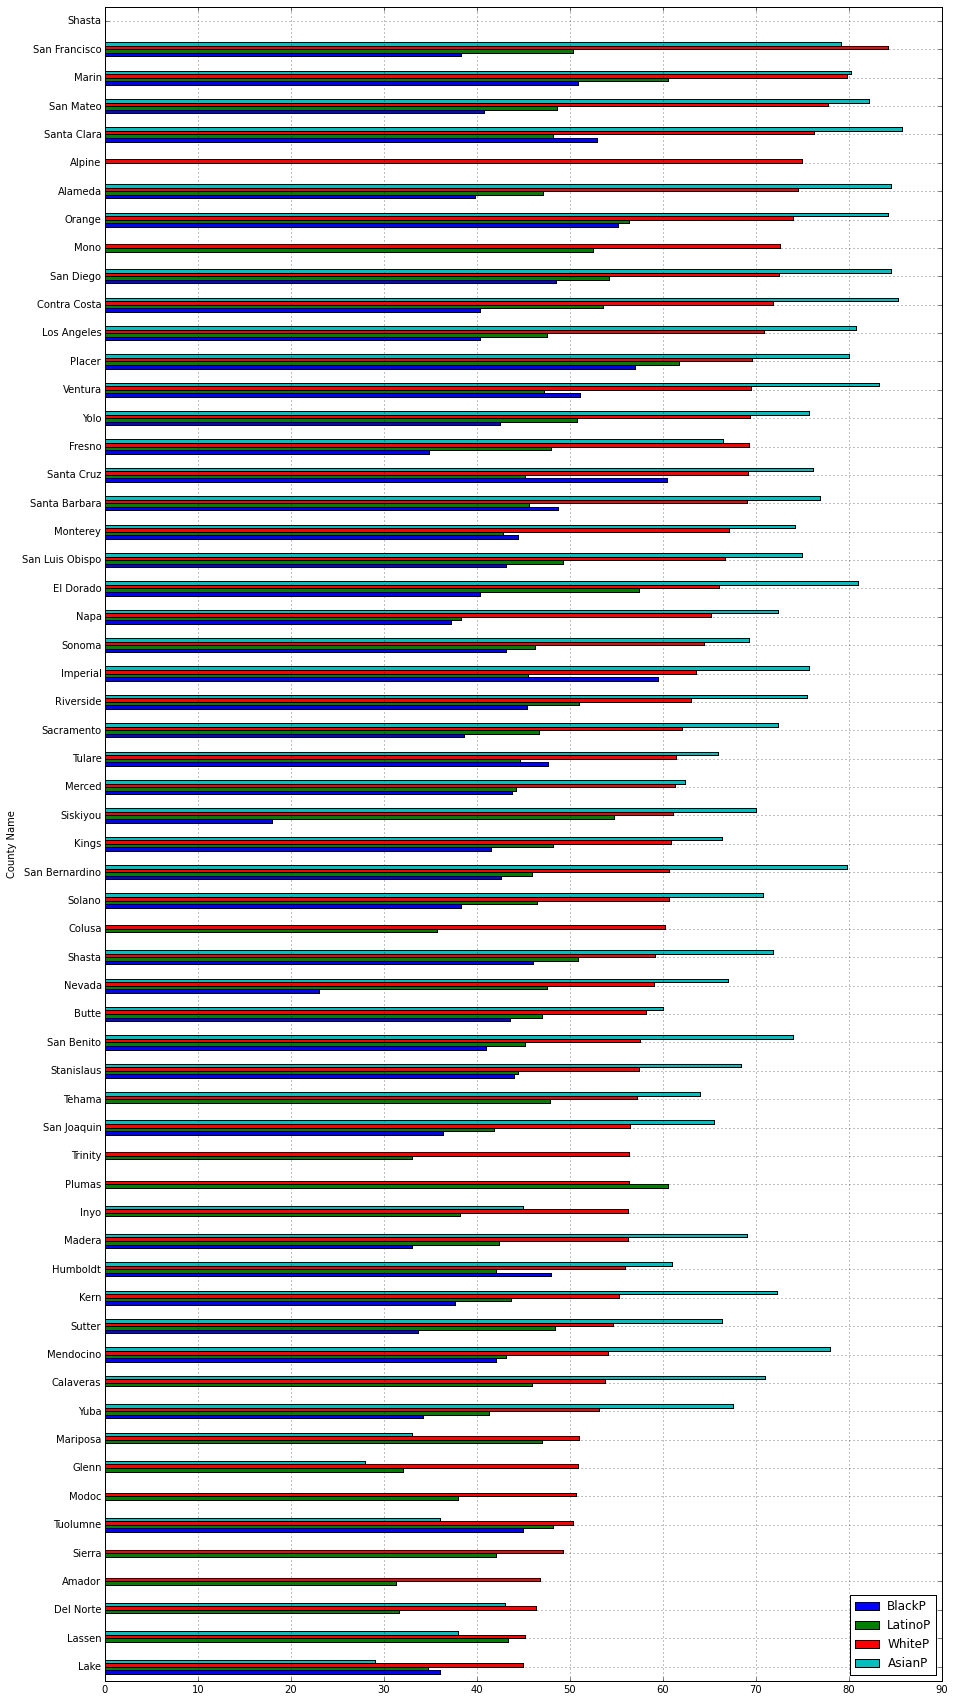

In [133]:
county_p_race_j[['BlackP','LatinoP','WhiteP','AsianP']].sort('WhiteP').plot(kind='barh', figsize = (15,30))